# Approach

In this notebook, I download the luminal A and luminal B cancer samples from TCGA, view it, trim it to keep only the most variable genes across specified expression bins, and save the new datasets for simplicity. 

In [514]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# Load data

In [515]:
df = pd.read_csv('../luminalAB/mrna/brca_luma_vs_lumb_mrna_tmm_311samples.csv')
df.set_index('geneid', inplace=True)
print('There are {0} genes, and {1} individuals'.format(*df.shape))
df.head()

There are 18059 genes, and 311 individuals


,02bf5203-f9cd-4c5a-97b4-e5584dc22325,02f5ae33-a563-4ecb-9e33-dfa500a44931,035cb359-eac3-484a-9e88-3ddc739440a3,0772cdbe-8b0d-452b-8df1-bd70d1306363,0807435a-e75e-4e04-8e45-ed0cd49a841a,08306ede-e74b-4be9-b768-7fd98647b6ac,08740d7f-5a5e-4dfa-bd48-7fbf228a7a28,09765b0a-94f6-47d2-af56-93368084ac3a,0a2a3529-f645-4967-9a58-89ee20b8bb62,0adf59c6-581a-475d-a2f4-40aa40060b5b,...,9ad603dc-3fd0-44f5-ae4e-64eeb1ae8d6d,9da462b0-93c2-4305-89f6-7199a30399a7,a991644b-3ee6-4cda-acf0-e37de48a49fc,b0f8d698-a30e-4d8d-b0a2-a5a01fac8406,bfd49783-1767-469b-9d79-7822301c5efc,d7cac141-9269-4733-83ce-e1bc0b503254,da1c58a7-c6bd-47d9-95c2-8d2ac70e20e4,de75d0b9-0f47-4732-8df5-05c350cfcd32,e6b79d7a-ed6b-459a-b040-d142616e7ab4,e89a9deb-6321-4e61-b412-b4993d4277dd
geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,45.076,82.887,16.960,62.010,62.903,48.839,35.288,81.780,39.394,14.679,...,9.581,37.866,79.568,36.760,38.857,32.849,45.781,27.675,23.508,31.715
ENSG00000000005,0.384,1.136,1.431,1.432,0.000,1.036,0.071,0.511,0.064,0.000,...,0.072,0.154,0.269,5.316,10.255,0.079,0.201,0.659,0.460,0.000
ENSG00000000419,24.944,28.838,28.492,24.951,31.068,23.145,25.018,28.945,34.270,44.993,...,45.025,24.308,48.580,29.951,30.260,26.982,48.628,100.207,37.823,60.115
ENSG00000000457,50.551,45.100,41.472,22.060,65.504,38.495,32.445,26.020,34.227,22.993,...,36.318,48.490,32.129,29.182,36.027,28.436,24.337,22.099,31.059,36.289
ENSG00000000460,15.239,22.006,11.153,7.506,17.272,10.357,7.196,11.987,11.957,13.465,...,28.842,29.158,23.770,13.171,17.554,9.182,14.729,14.641,14.643,31.553


In [516]:
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)
meta.head()

,ID,cancer
2,02bf5203-f9cd-4c5a-97b4-e5584dc22325,Luminal_A
3,02f5ae33-a563-4ecb-9e33-dfa500a44931,Luminal_A
5,035cb359-eac3-484a-9e88-3ddc739440a3,Luminal_A
7,0772cdbe-8b0d-452b-8df1-bd70d1306363,Luminal_A
8,0807435a-e75e-4e04-8e45-ed0cd49a841a,Luminal_A


## Check how many cases of each cancer type there are:

In [517]:
meta.groupby('cancer').count()

,ID
cancer,
Luminal_A,199
Luminal_B,112


# View coefficient of variation vs mean to get an idea of variations in TMMs

Text(0, 0.5, '$\\sigma / \\mu$')

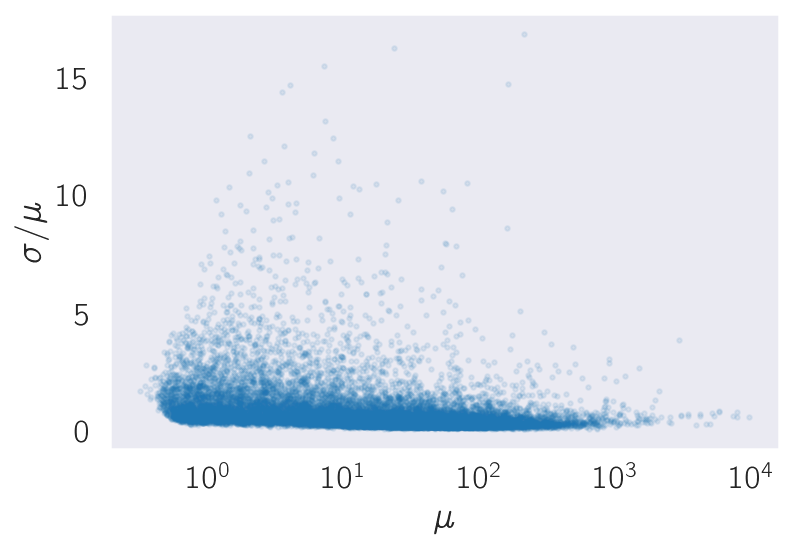

In [518]:
plt.scatter(df.mean(axis=1), df.std(axis=1) / df.mean(axis=1),
            s=5, alpha=0.1)
plt.xlabel('$\mu$')
plt.ylabel('$\sigma / \mu$')
plt.xscale('log')

# View gene expression distribution under basic transformations; hopefully one yields a normal-ish distribution

Text(0, 0.5, 'Frequency')

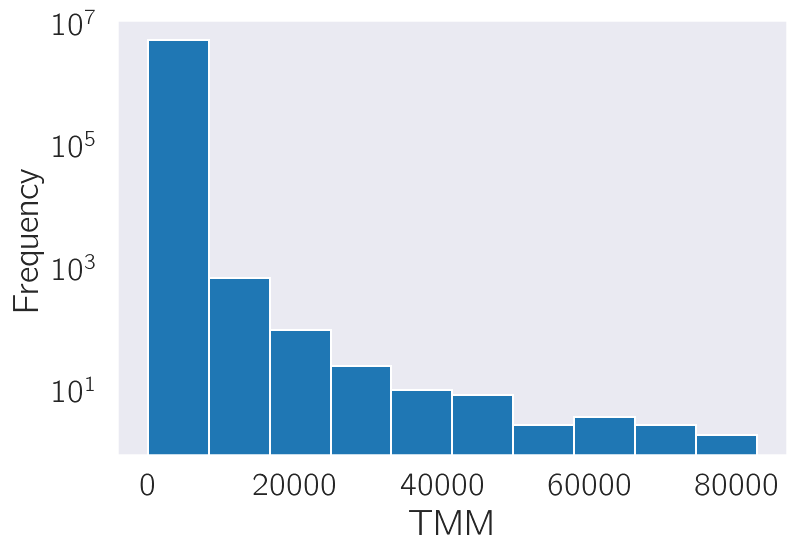

In [519]:
plt.hist(df.values.flatten())
plt.xlabel('TMM')
plt.ylabel('Frequency')
plt.yscale('log')

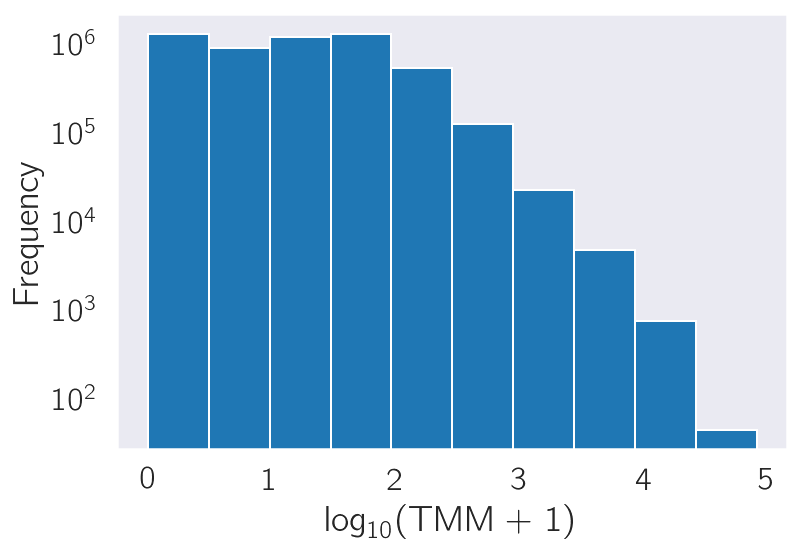

In [520]:
plt.hist((df + 1).apply(np.log10).values.flatten())
plt.xlabel('$\log_{10}$(TMM + 1)')
plt.ylabel('Frequency')
plt.yscale('log')

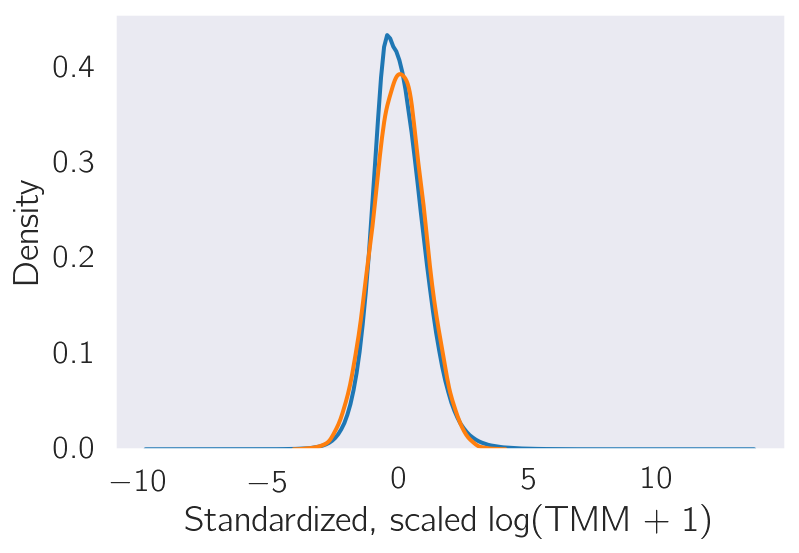

In [521]:
logdf = (df + 1).apply(np.log10)
normed = ((logdf - logdf.mean(axis=1).values[:, np.newaxis]) / logdf.std(axis=1).values[:, np.newaxis])

sns.kdeplot(normed.values.flatten(), label='data')
sns.kdeplot(np.random.normal(0, 1, len(normed)), label='normal dist')
_ = plt.xlabel('Standardized, scaled log(TMM + 1)')

# Trim genes that are not present in most samples. Sometimes this is important; here, not so much

There are 710 genes present in <300 samples


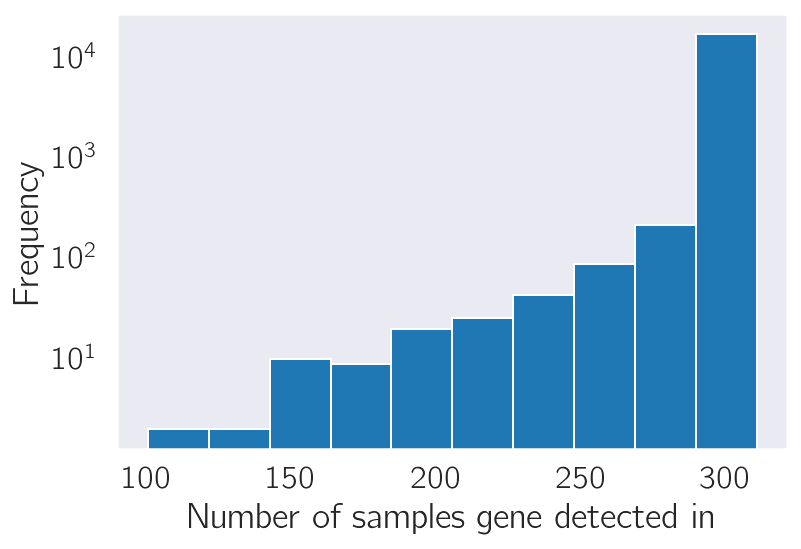

In [522]:
found = (df > 0).sum(axis=1)
plt.hist(found)
plt.yscale('log')
plt.xlabel('Number of samples gene detected in')
plt.ylabel('Frequency')

print('{0} genes show up in <300 samples'.format((found < 300).sum()))
df = df[found > 300]

# Bin genes by expression level, and select genes that are above the 60% percentile in their coefficient of variation per bin

Selecting variable genes at the 0.6 percentile
There are 6385 genes post-trimming


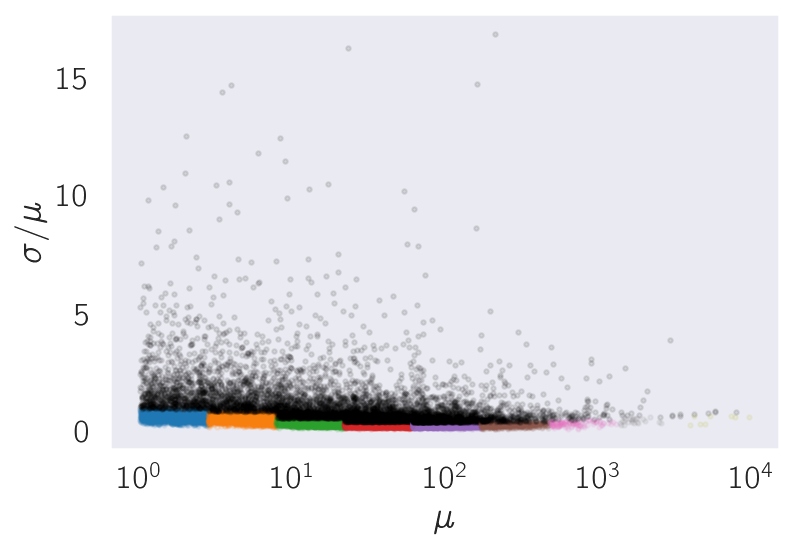

In [523]:
# split genes into expression percentiles:
percentile = 0.6
bins = np.logspace(0, 4, 10)
digital = np.digitize(df.mean(axis=1).values, bins=bins)
bin_means = np.array([df.mean(axis=1).values[digital == i].mean() for i in range(1, len(bins))])

# mean and coef of variation:
mean = df.mean(axis=1).values
cv = (df.std(axis=1) / df.mean(axis=1))

# for each bin, keep the top `percentile` most variable genes:
keep = []
for i in range(1, len(bins)):
    curr_cv = cv[digital == i].copy()
    idx = np.argsort(curr_cv)
    q = np.quantile(curr_cv, percentile)
    sel = (curr_cv > q)
    keep += curr_cv[sel].index.values.tolist()

    # plot genes by expression bin:
    plt.scatter(mean[digital == i][~sel], cv[digital == i][~sel], s=5, alpha=0.1)
    plt.scatter(mean[digital == i][sel], cv[digital == i][sel], s=5, alpha=0.1, color='black')

plt.xscale('log')
plt.xlabel('$\mu$')
plt.ylabel('$\sigma / \mu$')

df = df.loc[keep]
print('Selecting variable genes at the {0} percentile'.format(percentile))
print('There are {0} genes post-trimming'.format(len(df)))

# Post-trimming, transform and save dataframes

In [525]:
logdf = (df + 1).apply(np.log10)
scaled = (logdf - logdf.mean(axis=1).values[:, np.newaxis]) / logdf.std(axis=1).values[:, np.newaxis]

df.to_csv('../luminalAB/mrna/trimmedTMM.csv')
logdf.to_csv('../luminalAB/mrna/logTMM.csv')
scaled.to_csv('../luminalAB/mrna/NormalizedlogTMM.csv')